In [221]:
import os
import re

os.chdir("/home/s2113174/Projects-1")
#os.chdir("d://Projects//Projects-1/")

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from pyDOE import lhs
from scipy.stats import uniform,norm
from scipy.interpolate import griddata

from GaLa_v4 import llaplace

#np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Taylor Green Vortex

$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0 $$

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x}+ v\frac{\partial u}{\partial y} = - \frac{1}{\rho}\frac{\partial p}{\partial x} + \nu (\frac{\partial^{2} u}{\partial x^{2}} + \frac{\partial^{2} v}{\partial y^{2}})$$

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x}+ v\frac{\partial u}{\partial y} = - \frac{1}{\rho}\frac{\partial p}{\partial y} + \nu (\frac{\partial^{2} u}{\partial x^{2}} + \frac{\partial^{2} v}{\partial y^{2}})$$



where $0 \leq x,y \leq \pi$ and boundary conditions
$$u(x,0) = sin( x)e^{-2 \nu t}, u(x,\pi) = -sin( x)e^{-2 \nu t}$$
$$u(0,y) = u(\pi,y) =0 $$


$$v(0,y) = -sin( y)e^{-2 \nu t}, v(\pi,y) = -sin(y)e^{-2 \nu t}$$
$$v(x,0) = u(x,\pi) =0 $$

This equation has the following analytical solution.

$$u(x,y,t)= sin(x)cos(y)e^{-2 \nu t}$$
$$v(x,y,t)= -cos(x)sin(y)e^{-2 \nu t}$$

## Feed Forward Neural Network

In [224]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Parametric Neural PDE

In [226]:
def de(self,data_domain, ro = 1):
    """ The pytorch autograd version of calculating residual """
    f = self(data_domain)
    
    du = torch.autograd.grad(
        f[:,0], data_domain, 
        grad_outputs=torch.ones_like(f[:,0]),
        retain_graph=True,
        create_graph=True
    )[0]

    dv = torch.autograd.grad(
        f[:,1], data_domain, 
        grad_outputs=torch.ones_like(f[:,1]),
        retain_graph=True,
        create_graph=True
    )[0]

    dp = torch.autograd.grad(
        f[:,2], data_domain, 
        grad_outputs=torch.ones_like(f[:,2]),
        retain_graph=True,
        create_graph=True
    )[0]
    
    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    ddu_y = torch.autograd.grad(
        du[:,1],data_domain, 
        grad_outputs=torch.ones_like(du[:,1]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    ddv_x = torch.autograd.grad(
        dv[:,0],data_domain, 
        grad_outputs=torch.ones_like(dv[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    ddv_y = torch.autograd.grad(
        dv[:,1],data_domain, 
        grad_outputs=torch.ones_like(dv[:,1]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    r = du[:,0].reshape(-1,1) + dv[:,1].reshape(-1,1)
    g = du[:,2].reshape(-1,1) + f[:,0].reshape(-1,1) *du[:,0].reshape(-1,1) + f[:,1].reshape(-1,1)*du[:,1].reshape(-1,1) +\
                (1/ro)*dp[:,0].reshape(-1,1) - data_domain[:,-1].reshape(-1,1)*(ddu_x[:,0].reshape(-1,1) + ddu_y[:,1].reshape(-1,1))
    
    h = dv[:,2].reshape(-1,1) + f[:,0].reshape(-1,1)*dv[:,0].reshape(-1,1) + f[:,1].reshape(-1,1)*dv[:,1].reshape(-1,1) +\
                (1/ro)*dp[:,1].reshape(-1,1) - data_domain[:,-1].reshape(-1,1)*(ddv_x[:,0].reshape(-1,1) + ddv_y[:,1].reshape(-1,1))
    return torch.cat([r,g,h],axis = 1)

def down_bc(self,data_inic, ro = 1):
    f = self(data_inic)
    bc1 = f[:,0].reshape(-1,1) - torch.sin(data_inic[:,0].reshape(-1,1))*torch.exp(-2*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    bc3 = f[:,2].reshape(-1,1) -(ro/4)*torch.cos(2*data_inic[:,0].reshape(-1,1))*torch.exp(-4*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    return torch.cat([bc1,f[:,1].reshape(-1,1),bc3],axis = 1)

def up_bc(self,data_inic, ro = 1):
    f = self(data_inic)
    bc1 = f[:,0].reshape(-1,1) + torch.sin(data_inic[:,0].reshape(-1,1))*torch.exp(-2*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    bc3 = f[:,2].reshape(-1,1) -(ro/4)*torch.cos(2*data_inic[:,0].reshape(-1,1))*torch.exp(-4*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    return torch.cat([bc1,f[:,1].reshape(-1,1),bc3],axis = 1)

def left_bc(self,data_inic, ro = 1):
    f = self(data_inic)
    bc1 = f[:,1].reshape(-1,1) + torch.sin(data_inic[:,1].reshape(-1,1))*torch.exp(-2*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    bc3 = f[:,2].reshape(-1,1) -(ro/4)*(1+torch.sin(2*data_inic[:,1].reshape(-1,1)))*torch.exp(-4*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    return torch.cat([f[:,0].reshape(-1,1),bc1,bc3],axis = 1)

def right_bc(self,data_inic, ro = 1):
    f = self(data_inic)
    bc1 = f[:,1].reshape(-1,1) - torch.sin(data_inic[:,1].reshape(-1,1))*torch.exp(-2*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    bc3 = f[:,2].reshape(-1,1) -(ro/4)*(1+torch.sin(2*data_inic[:,1].reshape(-1,1)))*torch.exp(-4*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    return torch.cat([f[:,0].reshape(-1,1),bc1,bc3],axis = 1)

In [227]:
DNN.de = de
DNN.down_bc = down_bc
DNN.up_bc = up_bc
DNN.left_bc = left_bc
DNN.right_bc = right_bc

In [228]:
def samples_space(size = 10,maxl = np.pi):
    xyt = lhs(3, size)
    xyt[:,:2] = xyt[:,:2]*maxl
    xyt[:,-1] = xyt[:,-1]*10
    return xyt

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [229]:
def data_pde(size,minp,maxp):

    xyt, param = samples_space(size),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    pde_domain = torch.tensor(np.hstack((xyt,param.reshape(-1,1)))).float()
    
    x,y,t = torch.tensor(xyt[:,0]).reshape(-1,1),torch.tensor(xyt[:,1]).reshape(-1,1),torch.tensor(xyt[:,2]).reshape(-1,1)
    param = torch.tensor(param).reshape(-1,1)
    
    down_bc = torch.cat([x,torch.zeros_like(x).float(),t, param],axis = 1).float()

    up_bc = torch.cat([x,torch.ones_like(x).float()*(torch.pi),t, param],axis = 1).float()

    left_bc = torch.cat([torch.zeros_like(y).float(),y,t, param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(y).float()*(torch.pi),y,t, param],axis = 1).float()

    return pde_domain,down_bc,up_bc,left_bc,right_bc

In [230]:
def train_adam(pinn,loss,optimizer,epochs, sample_size = 100,minval_param = 0.2,maxval_param = 2,repetitions=1):
      print("Starting Adam Training")
      train_loss=[]
      
      for i in range(epochs):
        pde_domain,down_bc,up_bc,left_bc,right_bc = data_pde(sample_size,minval_param,maxval_param)
        pde_domain,down_bc,up_bc,left_bc,right_bc = pde_domain.to(device),down_bc.to(device),up_bc.to(device),left_bc.to(device),right_bc.to(device)

        pde_domain = Variable(pde_domain,requires_grad=True)
        down_bc,up_bc = Variable(down_bc,requires_grad=True),Variable(up_bc,requires_grad=True)
        left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
        
        for _ in range(repetitions):
                optimizer.zero_grad()

                pde_pred  = pinn.de(pde_domain)
                down_bc_pred,up_bc_pred = pinn.down_bc(down_bc),pinn.up_bc(up_bc)
                left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

                zeros = torch.zeros_like(pde_pred)

                loss_pde = loss(pde_pred,zeros)
                loss_dbc,loss_ubc = loss(down_bc_pred,zeros),loss(up_bc_pred,zeros)
                loss_lbc,loss_rbc = loss(left_bc_pred,zeros),loss(right_bc_pred,zeros)

                Loss =  3*(loss_pde + loss_dbc + loss_ubc + loss_lbc + loss_rbc)
                
                train_loss.append(Loss.item())

                if i % 10 == 0:
                        print('Iter %d, Loss: %.5e, Loss_pde: %.5e,Loss_dbc: %.5e,Loss_ubc: %.5e,Loss_lbc: %.5e,Loss_rbc: %.5e' % (i, 
                                                 Loss.item(),loss_pde.item(),loss_dbc.item(), loss_ubc.item(),loss_lbc.item(), loss_rbc.item()))      
                Loss.backward() 

                optimizer.step() 
                
      return train_loss

In [231]:
def train_LBFGS(pinn,loss,optimizer, sample_size = 100,minval_param = 0.2,maxval_param = 2):
    print("Starting Training: LBFGS optimizer")
    train_loss=[]

    pde_domain,down_bc,up_bc,left_bc,right_bc = data_pde(sample_size,minval_param,maxval_param)
    pde_domain,down_bc,up_bc,left_bc,right_bc = pde_domain.to(device),down_bc.to(device),up_bc.to(device),left_bc.to(device),right_bc.to(device)

    pde_domain = Variable(pde_domain,requires_grad=True)
    down_bc,up_bc = Variable(down_bc,requires_grad=True),Variable(up_bc,requires_grad=True)
    left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
    

    def loss_func_train():
        optimizer.zero_grad()
        
        pde_pred  = pinn.de(pde_domain)
        down_bc_pred,up_bc_pred = pinn.down_bc(down_bc),pinn.up_bc(up_bc)
        left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

        zeros = torch.zeros_like(pde_pred)

        loss_pde = loss(pde_pred,zeros)
        loss_dbc,loss_ubc = loss(down_bc_pred,zeros),loss(up_bc_pred,zeros)
        loss_lbc,loss_rbc = loss(left_bc_pred,zeros),loss(right_bc_pred,zeros)

        Loss =  3*(loss_pde + loss_dbc + loss_ubc + loss_lbc + loss_rbc)
        
        train_loss.append(Loss.item())

        print('Loss: %.5e, Loss_pde: %.5e,Loss_dbc: %.5e,Loss_ubc: %.5e,Loss_lbc: %.5e,Loss_rbc: %.5e' % ( 
                                        Loss.item(),loss_pde.item(),loss_dbc.item(), loss_ubc.item(),loss_lbc.item(), loss_rbc.item())) 
        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 
    return train_loss

In [232]:
# Number of observations
epochs = 5000
nobs = 1000
lr = 0.01

n_models = 10

min_param , max_param = 0.0001, 0.05

layers = [4] + 4*[80] + [3]
model = DNN(layers).to(device)

In [233]:
for n in range(n_models):
    model = DNN(layers).to(device)

    loss = torch.nn.MSELoss(reduction ='mean')

    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    loss_history = train_adam(model,loss,optimizer,epochs, nobs,min_param,max_param)

    optimizer = torch.optim.LBFGS(model.parameters(), 
        lr=lr, max_iter=50000, max_eval=None, 
        tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,
        line_search_fn="strong_wolfe" 
        )

    loss_history_b = train_LBFGS(model,loss,optimizer, nobs*2,min_param,max_param)

    path = "../Projects-1/Physics _Informed_NN/GaLA/Gala_models/model_{n}_TG.pt"
    torch.save(model.state_dict(),path)

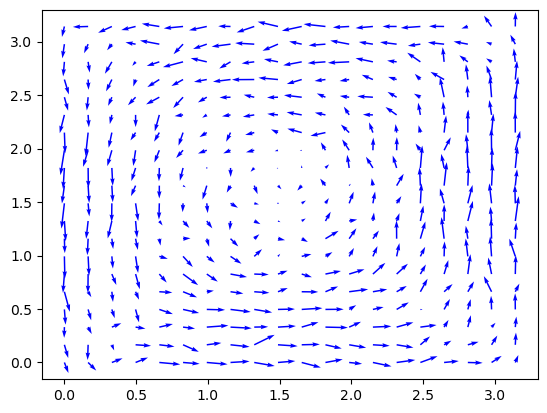

Text(0.5, 0, 'x')

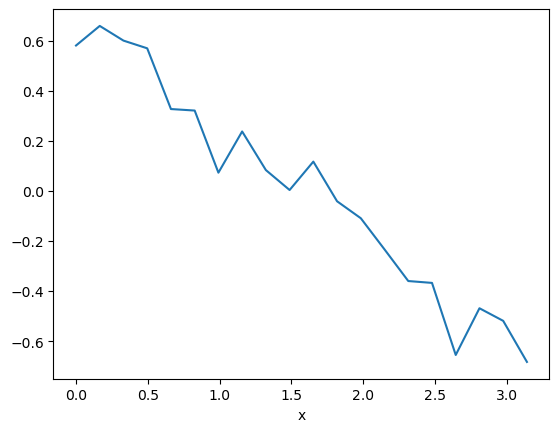

In [ ]:
x = np.linspace(0,1,20)*np.pi
y = np.linspace(0,1,20)*np.pi
t = np.linspace(0,2,10)
nu = 1/100

xx, yy = np.meshgrid(x, y)

xx, yy = torch.tensor(xx).reshape(-1,1).float().to(device),torch.tensor(yy).reshape(-1,1).float().to(device)

X_star = torch.cat([xx,yy,torch.ones_like(xx).to(device)*(t[0]),torch.ones_like(xx).to(device)*(nu)],axis = 1)

f = model(X_star)

xx, yy = np.meshgrid(x, y)

u = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f[:,0].cpu().detach().numpy().flatten(), (xx,yy), method='cubic')
v = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f[:,1].cpu().detach().numpy().flatten(), (xx,yy), method='cubic')

plt.quiver(x, y, u, v, color='blue') 
plt.show()
plt.plot(x,u[:,9])
plt.xlabel("x")